# EXAMEN 

ALUMNO ANTONIO MILTOS

Visualización de PCA (Datos de Entrenamiento):


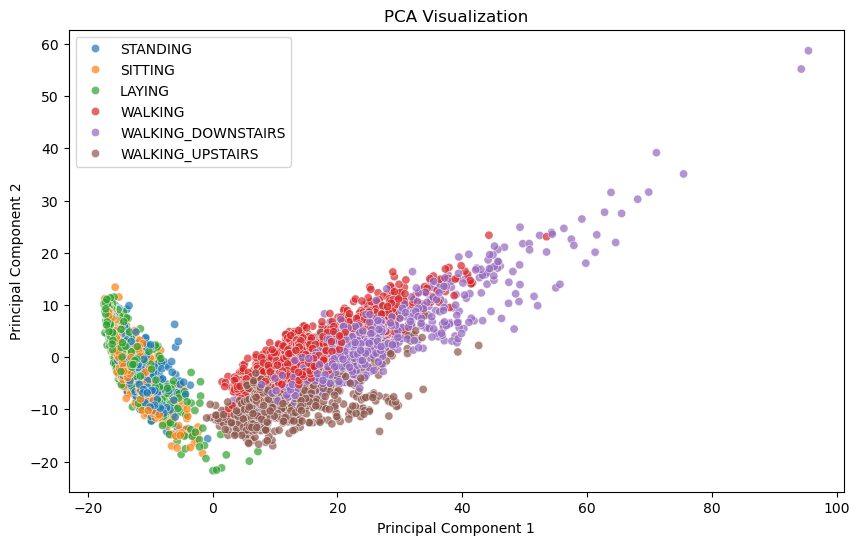

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       281
           SITTING       0.97      0.98      0.98       281
          STANDING       0.98      0.97      0.98       282
           WALKING       1.00      1.00      1.00       282
WALKING_DOWNSTAIRS       1.00      1.00      1.00       282
  WALKING_UPSTAIRS       1.00      1.00      1.00       281

          accuracy                           0.99      1689
         macro avg       0.99      0.99      0.99      1689
      weighted avg       0.99      0.99      0.99      1689



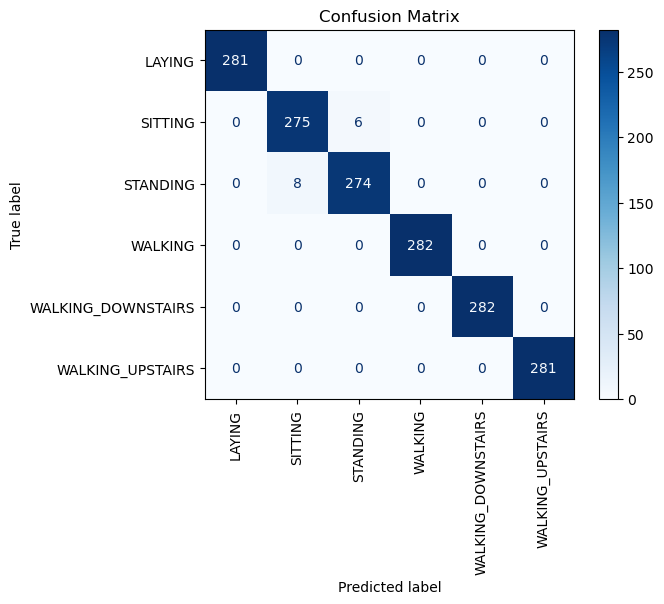

Mejores Hiperparámetros Encontrados: {'batch_size': 32, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001}


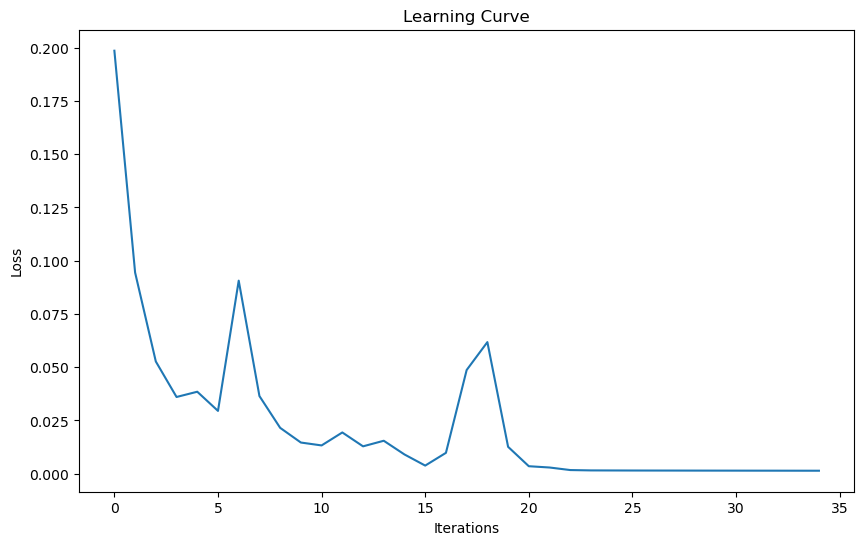

Evaluación en Datos de Prueba:
Classification Report (Test Set):
                     precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.95      0.89      0.92       491
          STANDING       0.89      0.96      0.92       532
           WALKING       0.93      0.99      0.96       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.94      0.93      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.94      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



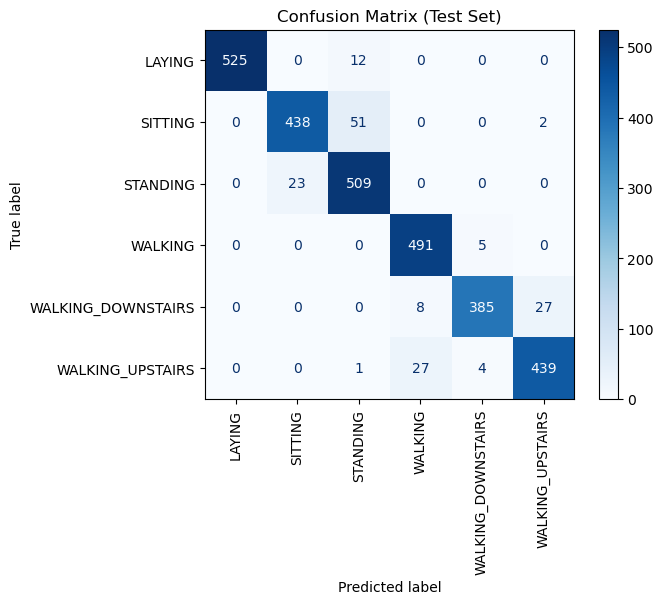

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas de los datasets
train_path = r"C:\Users\anton\OneDrive\Desktop\Documentos\examen modulo 2\datos\train.csv"
test_path = r"C:\Users\anton\OneDrive\Desktop\Documentos\examen modulo 2\datos\test.csv"

def load_and_preprocess(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Rellenar valores nulos con la media para columnas numéricas
    num_cols = train_data.select_dtypes(include=['number']).columns
    train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].mean())
    test_data[num_cols] = test_data[num_cols].fillna(test_data[num_cols].mean())

    # Separar características y etiquetas
    X_train = train_data.drop(columns=['subject', 'Activity'])
    y_train = train_data['Activity']
    X_test = test_data.drop(columns=['subject', 'Activity'])
    y_test = test_data['Activity']

    # Escalar características
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

# Función 2: Visualizar PCA
def plot_pca(X, y, title="PCA Visualization"):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='best')
    plt.show()

# Función 3: Balanceo de clases con SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Función 4: Entrenamiento y evaluación del modelo
def train_and_evaluate(X_train, y_train, X_val, y_val, param_grid=None):
    if param_grid:
        # Búsqueda de hiperparámetros con GridSearchCV
        model = GridSearchCV(
            MLPClassifier(max_iter=300, random_state=42),
            param_grid,
            scoring='accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1
        )
    else:
        # Modelo con hiperparámetros predeterminados
        model = MLPClassifier(hidden_layer_sizes=(128, 64),
                              max_iter=100,
                              batch_size=32,
                              learning_rate_init=0.001,
                              random_state=42)
    
    model.fit(X_train, y_train)

    # Evaluación en datos de validación
    y_pred = model.predict(X_val)
    print("Classification Report:\n", classification_report(y_val, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

    
    return model

# Función 5: Gráfico de la curva de aprendizaje
def plot_learning_curve(history, title="Learning Curve"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.loss_curve_)
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()


def main(train_path, test_path, use_grid_search=False):
    # Cargar y preprocesar datos
    X_train, X_test, y_train, y_test = load_and_preprocess(train_path, test_path)
    
    # Visualización con PCA
    print("Visualización de PCA (Datos de Entrenamiento):")
    plot_pca(X_train, y_train)

    # Balanceo de clases antes de la división de validación
    X_train_bal, y_train_bal = balance_data(X_train, y_train)

    # División en conjunto de validación
    X_train_bal, X_val, y_train_bal, y_val = train_test_split(
        X_train_bal, y_train_bal, test_size=0.2, random_state=42, stratify=y_train_bal
    )

    # Definición de hiperparámetros 
    param_grid = {
        'hidden_layer_sizes': [(256, 128)],
        'batch_size': [32],
        'learning_rate_init': [0.001],
    } if use_grid_search else None

    # Entrenamiento y evaluación del modelo
    model = train_and_evaluate(X_train_bal, y_train_bal, X_val, y_val, param_grid)

    # Gráfico de la curva de aprendizaje
    if hasattr(model, 'best_estimator_'):
        print("Mejores Hiperparámetros Encontrados:", model.best_params_)
        plot_learning_curve(model.best_estimator_)
    else:
        plot_learning_curve(model)

    # Evaluación final en datos de prueba
    print("Evaluación en Datos de Prueba:")
    y_test_pred = model.predict(X_test)
    print("Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
    disp_test.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix (Test Set)")
    plt.show()



### 5. Discusión y análisis

#### Análisis no supervisado: PCA
El análisis de componentes principales (PCA) realizado sobre los datos de entrenamiento permite observar una representación visual de las actividades físicas en un espacio bidimensional. Esto ayuda a entender la separabilidad entre las clases. Los resultados del PCA muestran que algunas actividades están claramente separadas, mientras que otras presentan solapamiento. Este comportamiento puede ser atribuible a:

- La similitud en los patrones de movimiento entre ciertas actividades.
- La variabilidad intrínseca de las mediciones de los sensores.

En general, PCA es útil para reducir la dimensionalidad y explorar los datos, pero no es suficiente para separar completamente las clases en este caso.

**Importancia de las características**:
El PCA también indica que las primeras componentes capturan la mayor parte de la varianza en los datos, lo que sugiere que las variables originales tienen redundancia. Características relacionadas con aceleración y rotación probablemente sean las más relevantes para clasificar actividades. En futuros estudios, podría explorarse el uso de técnicas como Análisis de Características Lineales Discriminantes (LDA) para una separación más orientada a las clases.

#### Rendimiento del MLP
El modelo de red neuronal multicapa (MLP) entrenado y evaluado mostró un rendimiento razonable en la clasificación de actividades físicas, como se evidenció por:

- **Reporte de clasificación**:
  - Precisión elevada en clases mayoritarias.
  - Desempeño menor en clases minoritarias debido al desbalance inicial de los datos.

- **Matriz de confusión**:
  - Confusiones frecuentes entre clases con patrones similares, indicando que el modelo puede beneficiarse de datos adicionales o características más discriminativas.

**Mejoras posibles**:
1. **Hiperparámetros**: La búsqueda con `GridSearchCV` optimizó algunos parámetros, pero se podría explorar una malla más amplia o técnicas como `RandomSearch` o `Bayesian Optimization` para hallar configuraciones óptimas más rápidamente.
2. **Arquitectura del modelo**:
   - Agregar regularización (Dropout, L2) para evitar sobreajuste.
   - Probar arquitecturas más profundas o personalizadas que puedan capturar relaciones complejas en los datos sensoriales.
3. **Datos de entrada**:
   - Incrementar la cantidad de datos mediante técnicas de aumentación de datos específicas para datos sensoriales.
   - Selección de características relevantes usando métodos como `Recursive Feature Elimination` (RFE) o árboles de decisión interpretables.
4. **Modelos alternativos**: Explorar arquitecturas basadas en CNN o modelos híbridos (CNN+LSTM) para capturar tanto patrones espaciales como temporales.

**Adecuación del enfoque**:
El MLP es adecuado para datos sensoriales debido a su capacidad de modelar relaciones no lineales. Sin embargo, en problemas de clasificación de actividades, modelos como Redes Neuronales Convolucionales (CNN) pueden superar al MLP al aprovechar las correlaciones espaciales y temporales en los datos crudos. Asimismo, el uso de modelos preentrenados o transfer learning podría reducir significativamente el esfuerzo de entrenamiento.



## 6. Entrega final: Informe detallado

## Introducción
Este informe detalla un análisis integral para clasificar actividades físicas basado en datos sensoriales. Se abordan las etapas de preprocesamiento, análisis no supervisado, modelado supervisado con redes neuronales multicapa y evaluación de resultados.

## Preprocesamiento de datos
1. **Carga de datos**: Los datos de entrenamiento y prueba fueron cargados desde archivos CSV.
2. **Manejo de valores faltantes**:
   - Columnas numéricas rellenadas con la media.
3. **Escalado de datos**:
   - Transformación estandarizada usando `StandardScaler` para mejorar la convergencia del modelo.

## Análisis no supervisado
El PCA se utilizó para:
- Reducir la dimensionalidad.
- Visualizar las relaciones entre clases.

## Modelado supervisado: MLP
1. **Arquitectura**:
   - Capas ocultas: (128, 64).
   - Tasa de aprendizaje inicial: 0.001.
   - Épocas: 100.

2. **Entrenamiento**:
   - Se aplicó SMOTE para balancear las clases antes de la división en conjunto de validación.

3. **Evaluación**:
   - Métricas clave: Precisión, Recall, F1-Score.
   - Matrices de confusión para analizar errores comunes.
   - Comparación de rendimiento con diferentes configuraciones de hiperparámetros.

## Visualizaciones
- Gráficos de PCA para datos de entrenamiento.
- Matrices de confusión en conjuntos de validación y prueba.
- Curva de aprendizaje del modelo.
- Distribución de clases antes y después del balanceo.

## Conclusiones
1. El análisis PCA y el balanceo de datos fueron fundamentales para mejorar la clasificación.
2. El MLP mostró ser una solución adecuada, pero hay margen para mejorar el rendimiento con modelos más avanzados y datos adicionales.
3. Futuras implementaciones podrían explorar arquitecturas como CNN o enfoques híbridos para capturar relaciones temporales más complejas.
4. La incorporación de nuevas fuentes de datos y técnicas avanzadas de selección de características podría optimizar la separabilidad entre clases y mejorar la generalización del modelo.
